# Try GRASS GIS in Jupyter Notebook with Python

[<img src="grass_gis_logo.png" alt="GRASS GIS" style="width:200px;"/>](https://grass.osgeo.org/)

This is a quick introduction into *GRASS GIS* in a *Jupyter Notebook* using the *Python* scripting language.
The interactive notebook is available online thanks to the [*Binder*](https://mybinder.org/) service.

Examples here are using a sample GRASS GIS dataset for North Carolina, USA. The dataset is included in this environment.

## Usage

To run the selected part which is called a cell, hit `Shift + Enter`.

## Start

There is several ways how GRASS GIS can be used. When using Python in notebook, we usually find GRASS GIS Python packages, import them, initialize GRASS GIS session, and set several variables useful for using GRASS GIS in a notebook.

In [16]:
# Import Python standard library and IPython packages we need.
import os
import sys
import subprocess
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# show matplotlib outputs automatically in the notebook
%matplotlib inline

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.script.setup as gsetup

# Create a GRASS GIS session.
rcfile = gsetup.init(gisbase, "data/data", "nc_basic_spm_grass7", "user1")

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default).
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Watersheds

Now that we have GRASS GIS running in our notebook, let's try some basic commands. 

In this section, we create watersheds from elevation. First, we set computational region and create a map showing the elevation of the sample GRASS GIS dataset for North Carolina, USA.

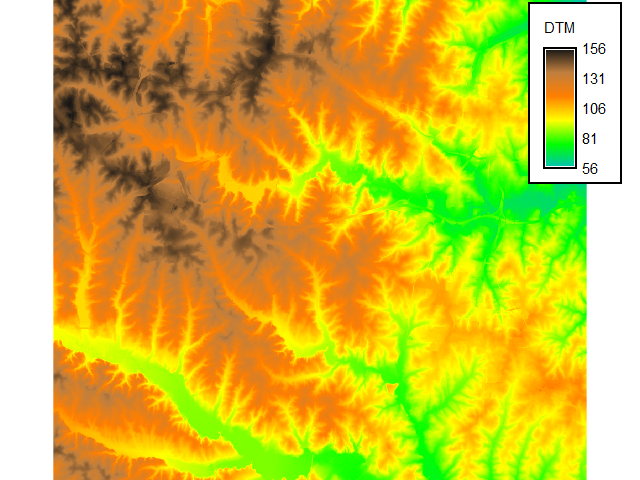

In [17]:
# Set computational region to the study area.
gs.parse_command('g.region', raster="elevation", flags='pg')
# Draw elevation (DTM) to get an overview of the area.
gs.run_command('d.erase')
gs.run_command('d.rast', map="elevation")
gs.run_command('d.legend', raster="elevation", at=(65, 90, 85, 90), fontsize=15, flags="b", title="DTM")
Image(filename="map.png")

From the elevation raster, we compute the watersheds and display the results. 

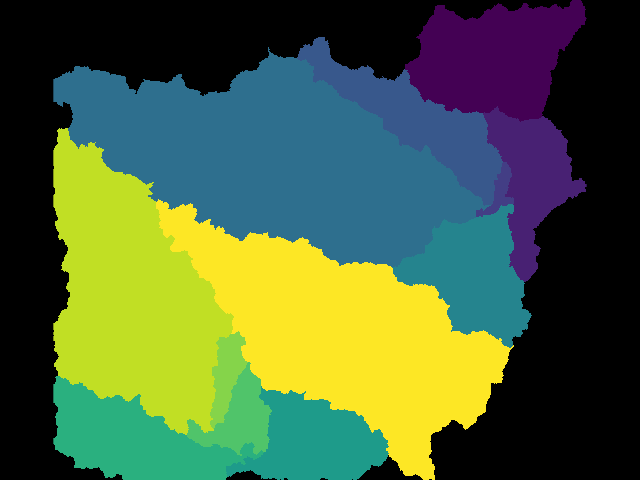

In [18]:
# Determine watersheds.
gs.run_command("r.watershed", elevation="elevation", basin="watersheds", threshold=80000)
# View them.
gs.run_command("r.colors", map="watersheds", color="viridis")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds")
Image(filename="map.png")

## Compute zonal statistics
In this section, we compute mean elevation and standard deviation in each watershed then make a bar plot to compare the watersheds. Each watershed is a zone.

We start by getting the univariate zonal statistics of elevtation as a CSV.

In [19]:
separator = "|"
text = gs.read_command("r.univar", map="elevation", zones="watersheds", separator=separator, flags="t")
reader = csv.DictReader(text.splitlines(), delimiter=separator)

Restructure the table of statistics as a dictionary by watershed (zone).

In [20]:
univars_for_watersheds = {}
for row in reader:
    category = row["zone"]
    univars_for_watersheds[category] = row

Get watersheds as a list of strings with `r.describe`. By using the `"1n"` flag, we ask `r.describe` not to returns nulls since they denote incomplete watersheds.

In [21]:
categories = gs.read_command("r.describe", flags="1n", map="watersheds").splitlines()

For each watershed (category), we compute the mean and standard deviation of the elevations as lists.

In [22]:
# Initiate empty list
means_for_streams = []
stddev_for_streams = []

# Compute mean and standard deviation in each watershed
for category in categories:
    means_for_streams.append(float(univars_for_watersheds[category]["mean"]))
    stddev_for_streams.append(float(univars_for_watersheds[category]["stddev"]))

Create a plot showing the mean and standard deviation of each watershed

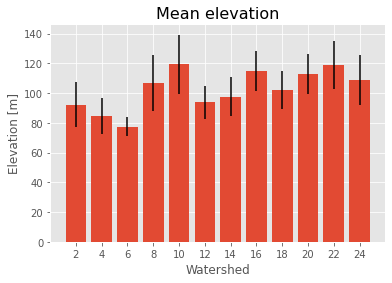

In [23]:
bar_positions = np.arange(len(categories))
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.set_title("Mean elevation", fontsize=16)
ax.set_xlabel("Watershed")
ax.set_ylabel("Elevation [m]")
ax.bar(bar_positions, means_for_streams, yerr=stddev_for_streams)
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories)
plt.show()

## Creating Choropleth Maps with Zonal Statistics
As an alternative to `r.univar`, we can use `r.stats.zonal` which offers a few additional methods such as skew and kurtosis. 

The output of `r.stats.zonal` is a raster so we can make nice maps of our zonal statistics.

Begin by computing the average elevation in each watershed.

In [86]:
gs.run_command("r.stats.zonal", base="watersheds", cover="elevation", method="average", output="watersheds_elev_avg")

Display the resulting average elevation map.

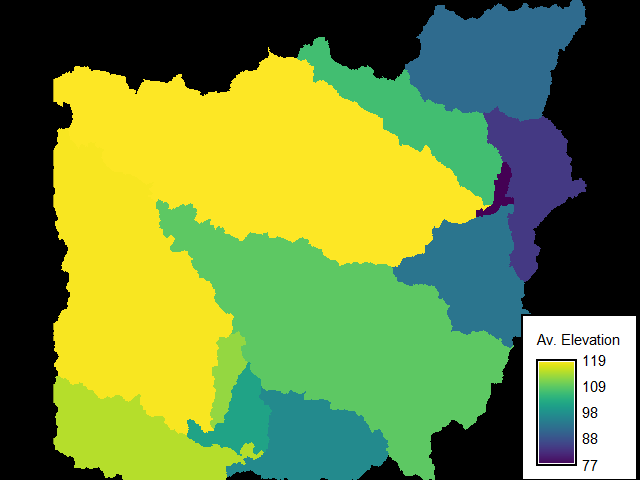

In [85]:
gs.run_command("r.colors", map="watersheds_elev_avg", color="viridis")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds_elev_avg")
gs.run_command('d.legend', raster="watersheds_elev_avg", at=(3, 25, 84, 90), fontsize=15, flags="b", title="Av. Elevation")
Image(filename="map.png")

## Watershed Area

Use the `"count"` method in `r.stats.zonal` to make a map of watershed area.

In [68]:
gs.run_command("r.stats.zonal", base="watersheds", cover="elevation", method="count", output="watersheds_count")

Convert cell count to area by multiplying by cell size (N-S resolution * E-W resolution) and convert to square kilometers.

In [102]:
# Get projection resolution
proj = gs.parse_command("g.region", flags="m")

# Multiply N-S resolution by E-W resolution to get cell area
cell_area = float(proj['nsres'])*float(proj['ewres'])

# Covert cell count to area
exp = "'watersheds_area' = ('watersheds_count'*{})/1000000".format(cell_area)
gs.run_command("r.mapcalc", expression=exp)

Display map of watershed areas.

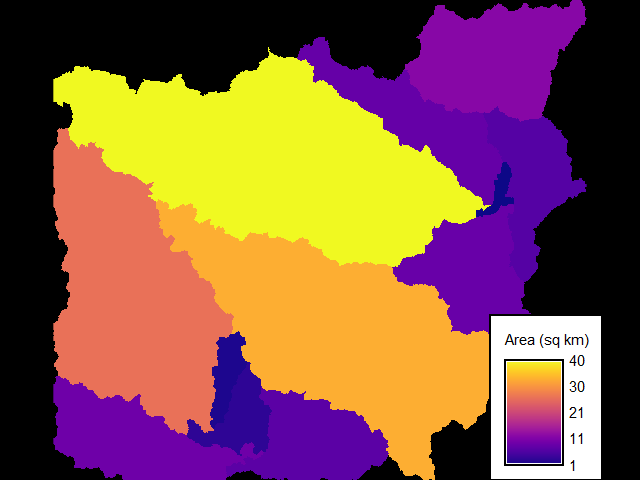

In [103]:
gs.run_command("r.colors", map="watersheds_area", color="plasma")
gs.run_command('d.erase', background="black")
gs.run_command('d.rast', map="watersheds_area")
gs.run_command('d.legend', raster="watersheds_area", at=(3, 25, 79, 88), fontsize=15, flags="b", title="Area (sq km)")
Image(filename="map.png")

## Converting to Vectors

Convert watersheds from raster to vector to make .

In [99]:
gs.run_command("r.to.vect", flags="s", input="watersheds", output="watersheds_vector", type="area")

Overlay outline of watershed on elevation map.

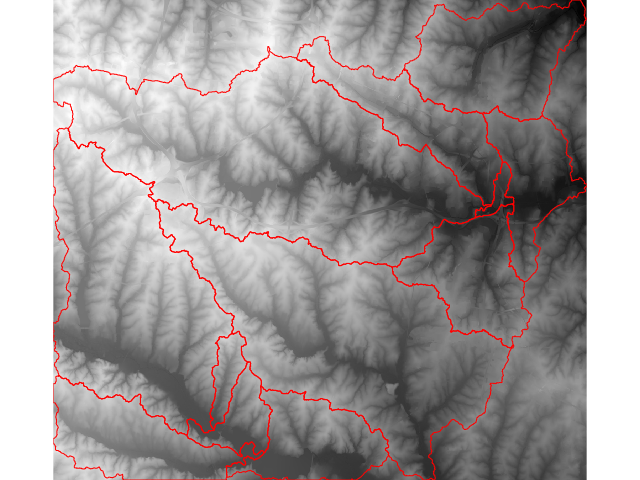

In [101]:
gs.run_command("v.colors", flags = "r", map="watersheds_vector")
gs.run_command("r.colors", map="elevation", color="grey")

gs.run_command('d.erase')
gs.run_command('d.rast', map="elevation")
gs.run_command('d.vect', map="watersheds_vector", fill_color="none", color="red")
Image(filename="map.png")